In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [18]:
data = Path('../data/model_data.parquet')
df = pd.read_parquet(data)

print("Data loaded:", df.shape)
df.head()

Data loaded: (4076302, 14)


,Purchase price,Area,price_per_m,suburb_median_price,suburb_price_growth,zoning_median_price,zoning_growth,sale_year,sale_month,sale_quarter,Year,Property post code,Zoning,price_log
100715,283800,442.6,641.211026,280000.0,0.0,362000.0,0.0,2000,11,4,2000,2150,A,12.556029
546864,385000,NaN,<NA>,470000.0,0.0,<NA>,<NA>,2000,3,1,2000,2000,None,12.861001
743963,385000,NaN,<NA>,437500.0,0.0,<NA>,<NA>,2000,3,1,2000,2000,None,12.861001
42136,787500,414.2,1901.255432,407500.0,0.0,440000.0,0.0,2000,12,4,2000,2134,B,13.57662
17423,160000,897.9,178.193563,134975.0,0.0,362000.0,0.0,2000,12,4,2000,2444,A,11.982935


In [ ]:
features = [
    'Area',
    'price_per_m',
    'suburb_median_price',
    'suburb_price_growth',
    'zoning_median_price',
    'zoning_growth',
    'sale_year',
    'sale_month',
    'sale_quarter',
    'Property post code',
    'Zoning'
]

features = [c for c in features if c in df.columns]
print("Using features:", features)

Using features: ['Area', 'price_per_m', 'suburb_median_price', 'suburb_price_growth', 'zoning_median_price', 'zoning_growth', 'sale_year', 'sale_month', 'sale_quarter', 'Property post code', 'Zoning', 'Area_missing', 'price_per_m_missing', 'suburb_median_price_missing']


In [38]:
train = df[df['Year'] < 2020].copy()
valid = df[(df['Year'] >= 2020) & (df['Year'] < 2024)].copy()
test = df[df['Year'] >= 2024].copy()

print("Train:", len(train), "Valid:", len(valid), "Test:", len(test))

Train: 3091890 Valid: 674750 Test: 309662


In [45]:
X_train = train[features].copy()
X_valid = valid[features].copy()
X_test = test[features].copy()

y_train = train['price_log'].copy()
y_valid = valid['price_log'].copy()
y_test = test['price_log'].copy()

print("X_train shape:", X_train.shape)


X_train shape: (3091890, 14)


In [46]:
X_train['Property post code'] = X_train['Property post code'].astype(str)
X_valid['Property post code'] = X_valid['Property post code'].astype(str)
X_test['Property post code']  = X_test['Property post code'].astype(str)

cat_feature_names = [c for c in features if X_train[c].dtype == 'object']
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_feature_names]

print("Categorical feature names:", cat_feature_names)
print("Categorical feature indices:", cat_feature_indices)


Categorical feature names: ['Property post code', 'Zoning']
Categorical feature indices: [9, 10]


In [47]:
for col in cat_feature_names:
    X_train[col] = X_train[col].astype(str).fillna('UNKNOWN')
    X_valid[col] = X_valid[col].astype(str).fillna('UNKNOWN')
    X_test[col]  = X_test[col].astype(str).fillna('UNKNOWN')

cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_feature_names]

In [48]:
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

In [49]:
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=8,
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

model.fit(train_pool, eval_set=valid_pool)

0:	learn: 0.6868279	test: 0.9071486	best: 0.9071486 (0)	total: 940ms	remaining: 15m 38s
100:	learn: 0.2733804	test: 0.2831894	best: 0.2831894 (100)	total: 1m	remaining: 8m 59s
200:	learn: 0.2470140	test: 0.2469532	best: 0.2469532 (200)	total: 2m 4s	remaining: 8m 16s
300:	learn: 0.2380974	test: 0.2351360	best: 0.2351360 (300)	total: 3m 1s	remaining: 7m 1s
400:	learn: 0.2340241	test: 0.2307336	best: 0.2307336 (400)	total: 4m	remaining: 5m 58s
500:	learn: 0.2316233	test: 0.2285282	best: 0.2285282 (500)	total: 5m 6s	remaining: 5m 5s
600:	learn: 0.2298164	test: 0.2274196	best: 0.2273588 (596)	total: 6m	remaining: 3m 59s
700:	learn: 0.2286438	test: 0.2267591	best: 0.2267474 (696)	total: 6m 50s	remaining: 2m 55s
800:	learn: 0.2277891	test: 0.2264822	best: 0.2264391 (784)	total: 7m 48s	remaining: 1m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2264050659
bestIteration = 805

Shrink model to first 806 iterations.


In [52]:
log = model.predict(test_pool)
price = np.expm1(log)
true_price = np.expm1(y_test)

mae = mean_absolute_error(true_price, price)
rmse = np.sqrt(mean_squared_error(true_price, price))
r2 = r2_score(true_price, price)

print("Test results:")
print(f"MAE : {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R2  : {r2:.4f}")

Test results:
MAE : 138,271.98
RMSE: 1,060,237.12
R2  : 0.5593


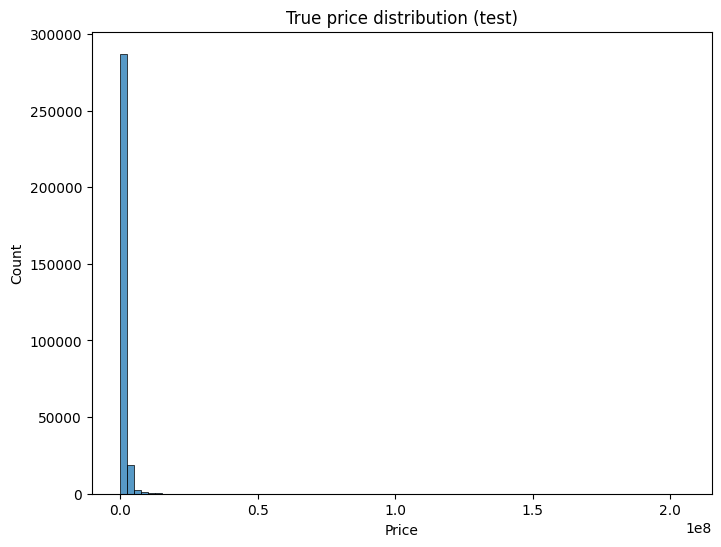

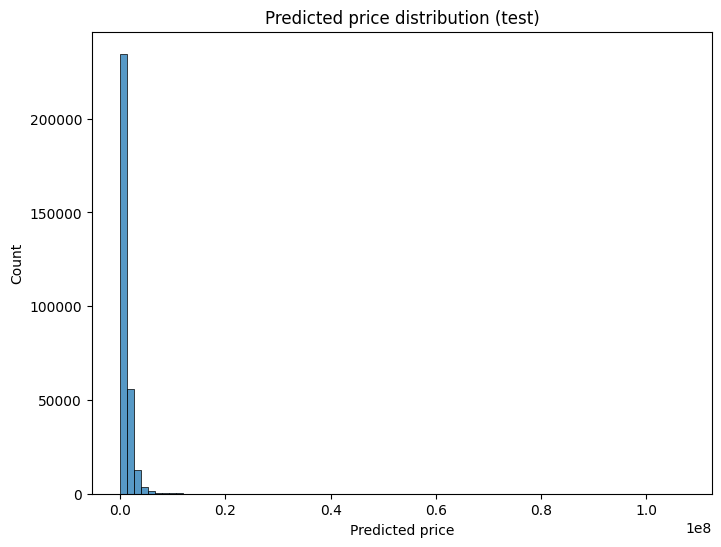

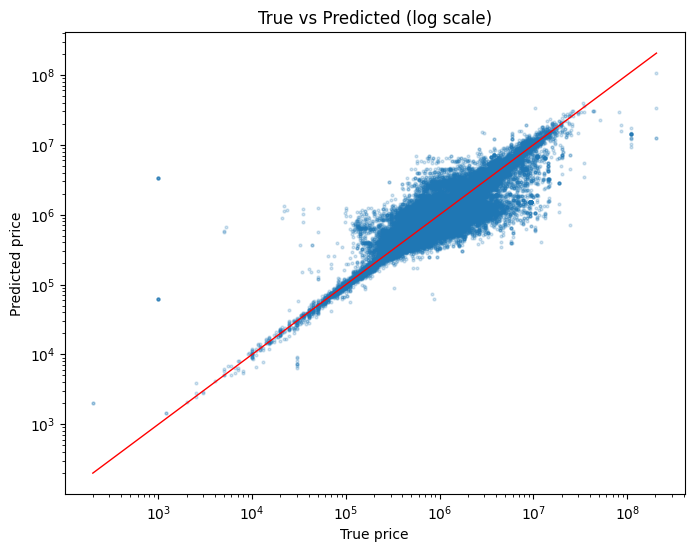

In [55]:
plt.figure(figsize=(8,6))
sns.histplot(np.expm1(y_test), kde=False, bins=80)
plt.title("True price distribution (test)")
plt.xlabel("Price")
plt.show()

plt.figure(figsize=(8,6))
sns.histplot(price, kde=False, bins=80)
plt.title("Predicted price distribution (test)")
plt.xlabel("Predicted price")
plt.show()

plt.figure(figsize=(8,6))
plt.scatter(true_price, price, s=4, alpha=0.2)
plt.xscale('log'); plt.yscale('log')
plt.xlabel('True price'); plt.ylabel('Predicted price')
plt.title('True vs Predicted (log scale)')
plt.plot([true_price.min(), true_price.max()], [true_price.min(), true_price.max()], color='r', lw=1)
plt.show()

In [56]:
try:
    fi = model.get_feature_importance(prettified=True)
    display(fi.head(30))
except Exception:
    raw_fi = model.get_feature_importance()
    sorted_idx = np.argsort(raw_fi)[::-1][:20]
    for i in sorted_idx:
        print(X_train.columns[i], raw_fi[i])

,Feature Id,Importances
0,suburb_median_price,34.446038
1,price_per_m,32.404886
2,Area,28.661781
3,Property post code,1.992479
4,zoning_median_price,0.949761
5,sale_year,0.747160
6,Zoning,0.617777
7,zoning_growth,0.063839
8,sale_month,0.052833
9,suburb_price_growth,0.039195


In [ ]:
model.save_model(str('saved_models/baseline_catboost_price_log.cbm'))
print("Saved model to:", 'saved_models/baseline_catboost_price_log.cbm')

CatBoostError: (Error 2: No such file or directory) util/system/file.cpp:936: can't open "saved_models/baseline_catboost_price_log.cbm" with mode WrOnly|CreateAlways|Seq (0x00000034)